Demonstrates a test for reproducibility with simple stochastic sampling of a sine wave. 

Requires matplotlib

In [1]:
from matplotlib import pyplot as plt
import numpy as np

import libssr

libssr.start_pool()

Generate samples

In [2]:
sizes_tested = [10, 50, 100, 500, 1000]
mean = 0.0
stdev = 0.25
t_final = 2 * np.pi
num_steps = 21
var_name = 'Y'
eval_num = 100
sig_figs = 8

times = np.asarray([t_final * x / (num_steps - 1) for x in range(num_steps)], dtype=float)


def generate_sample(_mean: float, _stdev: float, _size: int):
    result = np.ndarray((_size, num_steps), dtype=float)
    offset = np.random.normal(_mean, _stdev, _size)
    for i in range(_size):
        result[i, :] = libssr.round_arr_to_sigfigs(np.sin(times + offset[i]), sig_figs)
    return result


samples = {sz: generate_sample(mean, stdev, sz) for sz in sizes_tested}

Text(0.5, 0.98, 'Sample trajectories')

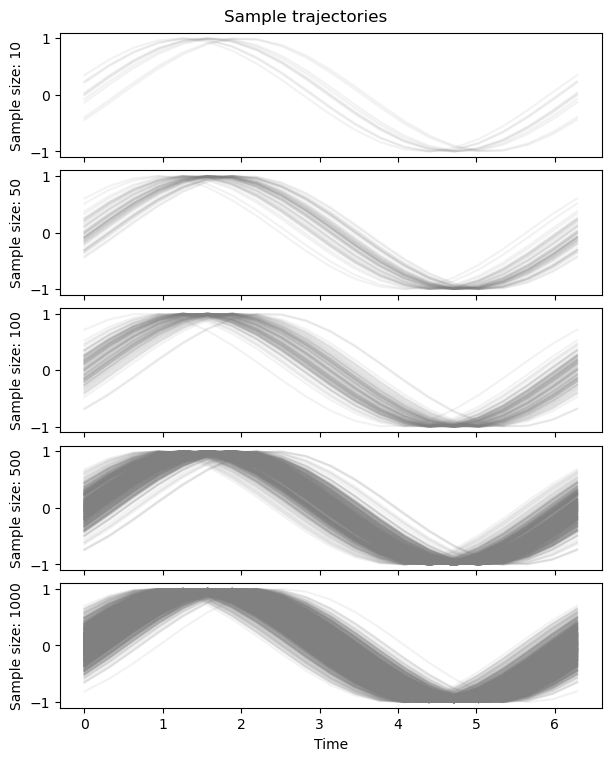

In [3]:
fig, ax = plt.subplots(len(sizes_tested), 1, layout='compressed', figsize=(6.0, 1.5 * len(sizes_tested)), sharex=True)
for i in range(len(sizes_tested)):
    sz = sizes_tested[i]
    for j in range(sz):
        ax[i].plot(times, samples[sz][j, :], color='gray', alpha=0.1)
    ax[i].set_ylabel(f'Sample size: {sz}')
ax[-1].set_xlabel('Time')
fig.suptitle('Sample trajectories')

Test for reproducibility

In [4]:
err_samples = {sz: libssr.test_reproducibility({var_name: samples[sz]})[0] for sz in sizes_tested}

In [5]:
err_means = {sz: np.mean(err_samples[sz]) for sz in sizes_tested}
err_stdevs = {sz: np.std(err_samples[sz]) for sz in sizes_tested}

Text(0.5, 0.98, 'Testing for reproducibility')

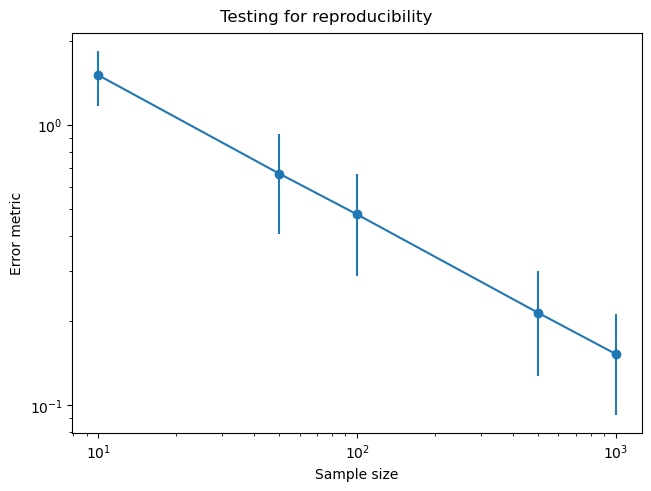

In [6]:
fig, ax = plt.subplots(layout='compressed')
ax.errorbar(sizes_tested, [err_means[sz] for sz in sizes_tested], yerr=[3 * err_stdevs[sz] for sz in sizes_tested], marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Sample size')
ax.set_ylabel('Error metric')
fig.suptitle('Testing for reproducibility')

Generate supporting data

In [7]:
size_export = int(sizes_tested[-1]/2)

ecf_evals = np.ndarray((num_steps, 1, eval_num, 2), dtype=float)
ecf_tval = np.ndarray((num_steps, 1), dtype=float)
for i in range(num_steps):
    sample_i = samples[sizes_tested[-1]][:size_export, i]
    ecf_tval[i, 0] = libssr.eval_final(sample_i)
    ecf_evals[i, 0, :, :] = libssr.ecf(sample_i, libssr.get_eval_info_times(eval_num, ecf_tval[i, 0]))

sdata = libssr.EFECTReport.create(
    variable_names = [var_name],
    simulation_times = times,
    sample_size = size_export,
    ecf_evals = ecf_evals,
    ecf_tval = ecf_tval,
    ecf_nval = eval_num,
    error_metric_mean = err_means[sizes_tested[-1]],
    error_metric_stdev = err_stdevs[sizes_tested[-1]],
    sig_figs = 8
)

Simulate testing reproduced results

In [8]:
# Extract a sample and test against another sample from the same distribution

half_sizes_tested = [int(sz/2) for sz in sizes_tested]

my_samples = {k: v[:int(k/2), :] for k, v in samples.items()}
anothers_samples = {k: generate_sample(mean, stdev, int(k/2)) for k in sizes_tested}
error_metrics = {sz: 0.0 for sz in sizes_tested}
pvals = {sz: 0.0 for sz in sizes_tested}

for sz in sizes_tested:
    for i in range(num_steps):
        eval_t = libssr.get_eval_info_times(eval_num, libssr.eval_final(my_samples[sz][:, i]))
        my_ecf = libssr.ecf(my_samples[sz][:, i], eval_t)
        anothers_ecf = libssr.ecf(anothers_samples[sz][:, i], eval_t)
        error_metrics[sz] = max(error_metrics[sz], libssr.ecf_compare(my_ecf, anothers_ecf))
    pvals[sz] = libssr.pvals(err_means[sz], err_stdevs[sz], error_metrics[sz], sz)

Text(0.5, 0.98, 'Testing for reproduced results (same distributions)')

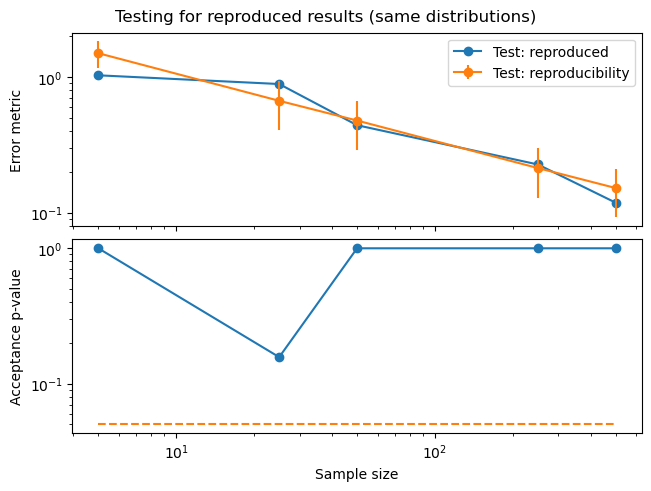

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True, layout='compressed')
ax[0].plot(half_sizes_tested, [error_metrics[sz] for sz in sizes_tested], marker='o', label='Test: reproduced')
ax[0].errorbar(half_sizes_tested, [err_means[sz] for sz in sizes_tested], yerr=[3 * err_stdevs[sz] for sz in sizes_tested], marker='o', label='Test: reproducibility')
ax[1].plot(half_sizes_tested, [pvals[sz] for sz in sizes_tested], marker='o')
ax[1].plot(half_sizes_tested, [0.05] * len(half_sizes_tested), linestyle='--')
for axi in ax:
    axi.set_xscale('log')
    axi.set_yscale('log')
ax[0].legend()
ax[0].set_ylabel('Error metric')
ax[1].set_ylabel('Acceptance p-value')
ax[1].set_xlabel('Sample size')
fig.suptitle('Testing for reproduced results (same distributions)')

In [10]:
# Test against another sample from a different distribution

anothers_samples_different = {k: generate_sample(mean + 1.0, stdev, int(k/2)) for k in sizes_tested}
error_metrics_different = {sz: 0.0 for sz in sizes_tested}
pvals_different = {sz: 0.0 for sz in sizes_tested}

for sz in sizes_tested:
    for i in range(num_steps):
        eval_t = libssr.get_eval_info_times(eval_num, libssr.eval_final(my_samples[sz][:, i]))
        my_ecf = libssr.ecf(my_samples[sz][:, i], eval_t)
        anothers_ecf = libssr.ecf(anothers_samples_different[sz][:, i], eval_t)
        error_metrics_different[sz] = max(error_metrics_different[sz], libssr.ecf_compare(my_ecf, anothers_ecf))
    pvals_different[sz] = libssr.pvals(err_means[sz], err_stdevs[sz], error_metrics_different[sz], sz)

Text(0.5, 0.98, 'Testing for reproduced results (different distributions)')

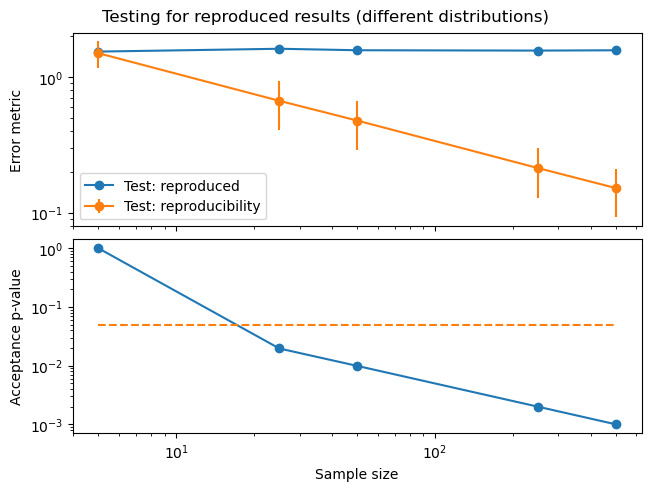

In [11]:
fig, ax = plt.subplots(2, 1, sharex=True, layout='compressed')
ax[0].plot(half_sizes_tested, [error_metrics_different[sz] for sz in sizes_tested], marker='o', label='Test: reproduced')
ax[0].errorbar(half_sizes_tested, [err_means[sz] for sz in sizes_tested], yerr=[3 * err_stdevs[sz] for sz in sizes_tested], marker='o', label='Test: reproducibility')
ax[1].plot(half_sizes_tested, [pvals_different[sz] for sz in sizes_tested], marker='o')
ax[1].plot(half_sizes_tested, [0.05] * len(half_sizes_tested), linestyle='--')
for axi in ax:
    axi.set_xscale('log')
    axi.set_yscale('log')
ax[0].legend()
ax[0].set_ylabel('Error metric')
ax[1].set_ylabel('Acceptance p-value')
ax[1].set_xlabel('Sample size')
fig.suptitle('Testing for reproduced results (different distributions)')